In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sb
sb.set_style('white')
import emcee 
import corner as corner 

# Metropolis-Hastings vs EMCEE

Basically the one big difference between a M-H sampler and a Ensemble sampler (emcee) is that, as the name say it, we have an ensable of "walkers" that move around the parameter space in sub-ensables, and the M-H only has one moving walker.

And what is the big deal? We can find high probability zones in less number of steps

In [2]:
chain_MH = np.loadtxt('data/MH_chain.dat')
chain_emcee = np.loadtxt('data/emcee_flatchain.dat')

In [3]:
labels = ['m','b','f']

## EMCEE

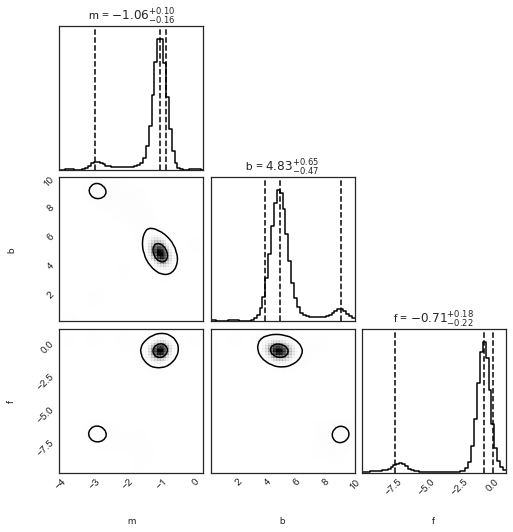

In [4]:
corner.corner(chain_emcee,labels=labels,bins=50,plot_datapoints=False,smooth=2., 
                    smooth1d=2.,levels=(1.-np.exp(-0.5),1.-np.exp(-2.)),quantiles=[.025,0.5,0.975],show_titles=True);

## Metropolis-Hastings

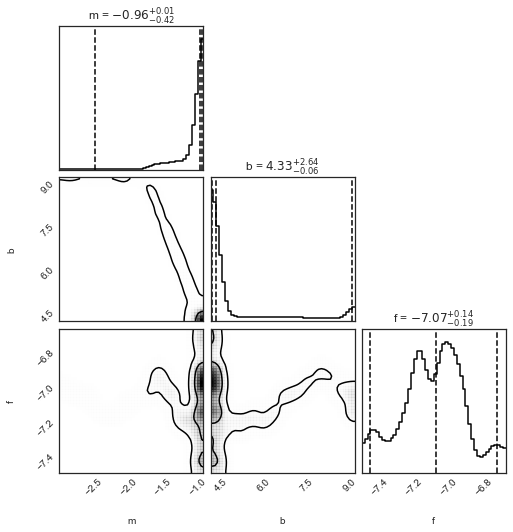

In [5]:
corner.corner(chain_MH,labels=labels,bins=50,plot_datapoints=False,smooth=2., 
                    smooth1d=2.,levels=(1.-np.exp(-0.5),1.-np.exp(-2.)),quantiles=[.025,0.5,0.975],show_titles=True);

In [6]:
m_true = -0.9594
b_true = 4.294

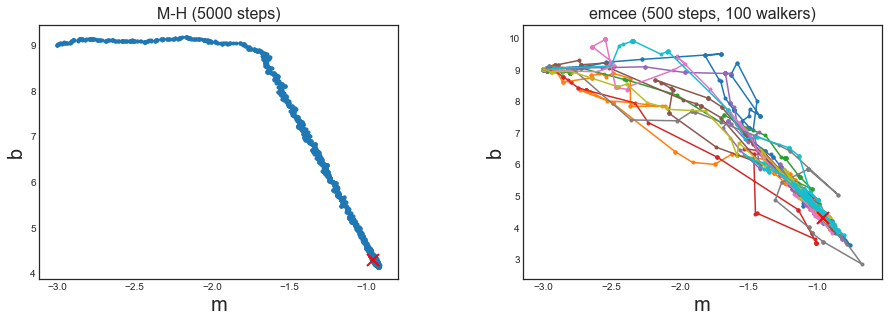

In [7]:
plt.figure()
plt.subplot(222)
for i in range(10):
    plt.scatter(chain_emcee.reshape((100,500,3))[i,:,0],chain_emcee.reshape((100,500,3))[i,:,1],marker='.');
    plt.plot(chain_emcee.reshape((100,500,3))[i,:,0],chain_emcee.reshape((100,500,3))[i,:,1]);
plt.plot(m_true,b_true,'xr',markersize=12,mew=2);
plt.title('emcee (500 steps, 100 walkers)',fontsize=16);
plt.xlabel('m',fontsize=20);
plt.ylabel('b',fontsize=20);

plt.subplot(221)
plt.scatter(chain_MH[:,0],chain_MH[:,1],marker='.');
plt.plot(chain_MH[:,0],chain_MH[:,1]);
plt.plot(m_true,b_true,'xr',markersize=12,mew=2);
plt.title('M-H (5000 steps)',fontsize=16);
plt.xlabel('m',fontsize=20);
plt.ylabel('b',fontsize=20);

plt.subplots_adjust(top=2., bottom=0.01, left=0.05, right=2.0, hspace=0.25,
                    wspace=.35)

# Now lets apply emcee to Supernova data

In [8]:
data_mu = np.loadtxt('data/jla_mub.txt').T

In [9]:
print len(data_mu[0])

31


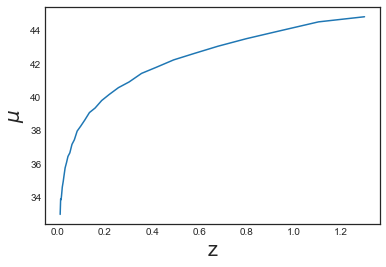

In [10]:
plt.plot(data_mu[0],data_mu[1]);
plt.xlabel('z',fontsize=20);
plt.ylabel(r'$\mu$',fontsize=20);

In this case the $\mu$ is the distance modulus of the supernova difined as 

$\mu = 25 - 5log_{10}h+5log_{10}(D^*_L)$

where $D^*_L = D_L(h=1)$ is the luminosity distance, that for a flat universe can be defined as:

$D_L(z) = \frac{c}{H0}(1+z)\left[\eta(1,\Omega_m)-\eta(\frac{1}{1+z},\Omega_m)\right]$,

with:

$\eta(a,\Omega_m) = 2\sqrt{s^3+1}\left[\frac{1}{a^4}-0.1540\frac{s}{a^3} + 0.4304\frac{s^2}{a^2} + 0.19097\frac{s^3}{a} + 0.66941s^4\right]^{-1/8}$

and: $s^3=(1-\Omega_m)/\Omega_m$

We start by construncting functions for $D_L(z)$, $\eta$ and $\mu$

In [11]:
def eta(pars,a):
    Omega_m = pars
    s = ((1.0-Omega_m)/Omega_m)**(1./3.)
    
    coefs = [0.1450,0.4304,0.19097,0.66941]
    
    val = a**-4 - coefs[0]*(s/a**3) + coefs[1]*(s/a)**2 + coefs[2]*(s**3/a) + coefs[3]*(s**4)
    
    return 2.0*np.sqrt(s**3 +1)*(val**(-1./8.))

In [12]:
def D_L(pars,z):
    Omega_m = pars
    a_0 = 1.0
    a = 1./(1. + z)
    c = 299792.0 #km/s
    
    val = eta(Omega_m,a_0) - eta(Omega_m,a)
    
    return (c/(a*100.)) * val

In [13]:
def mu(pars,z):
    Omega_m,h = pars
    
    val = 25.0 - (5.0 * np.log10(h)) + (5.0 * np.log10(D_L(Omega_m,z)))
    
    return val

In [14]:
cov_mat = np.loadtxt('data/jla_mub_covmatrix.dat')[1:]

In [15]:
print np.shape(cov_mat)

(961,)


In [16]:
cov_mat = cov_mat.reshape(31,31)

In [17]:
print np.shape(cov_mat)

(31, 31)


plot the covariance matrix

# Now we define our Likelihood and priors 

In [18]:
def log_like(pars,z,data,cov):
    model = mu(pars,z)
    
    coefs = data - model
    
    cov_inv = np.linalg.inv(cov)
    p = np.dot(coefs.T,np.dot(cov_inv,coefs))
    return -0.5*p

In [19]:
def priors(pars,plist):
    Omega_m, h = pars
    
    if plist[0]<Omega_m<plist[1] and plist[2]<h<plist[3]:
        return 0.0
    return -np.inf


In [20]:
def log_post(pars,z,data,cov,plist):
    prior = priors(pars,plist)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_like(pars,z,data,cov)

In [21]:
from scipy.optimize import minimize

In [22]:
fun = lambda *args: -log_like(*args)

In [23]:
results = minimize(fun,[.5,.5],args=(data_mu[0],data_mu[1],cov_mat),method='L-BFGS-B')

In [24]:
print results.x

[0.61663487 0.55354354]


In [25]:
p_list = [0.,1.,0.,1.]

In [26]:
nwalkers = 40
ndim = 2


In [27]:
z = np.zeros((ndim,nwalkers))

In [28]:
mid = [0.1,0.95]

In [29]:
h = 1e-2

pos_i=[]

for i in range(ndim):
    z[i,:] = mid[i] + h*np.random.randn(nwalkers)

for i in range(nwalkers):
    pos_i.append(np.array([z[0,i],z[1,i]]))

In [30]:
b_steps, steps = 200,800

In [31]:
sampler = emcee.EnsembleSampler(nwalkers, ndim,log_post, 
                                args=(data_mu[0],data_mu[1],cov_mat,p_list),
                                threads = 2)

In [32]:
pos,prob,state=sampler.run_mcmc(pos_i, b_steps)

In [33]:
print sampler.acceptance_fraction.mean()

0.607625


In [34]:
sampler.reset()

In [35]:
_,_,_=sampler.run_mcmc(pos, steps, rstate0=state)

In [36]:
print sampler.acceptance_fraction.mean()

0.71634375


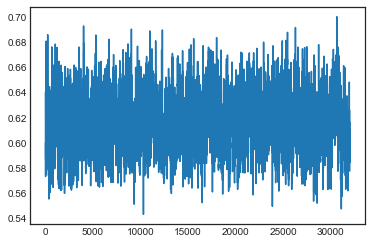

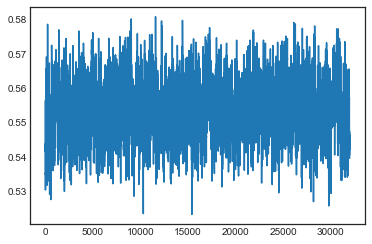

In [37]:
plt.figure()
plt.plot(sampler.flatchain[:,0]);
plt.figure()
plt.plot(sampler.flatchain[:,1]);

In [38]:
import corner as corner 

In [39]:
labels = [r'$\Omega_m$',r'$h$']

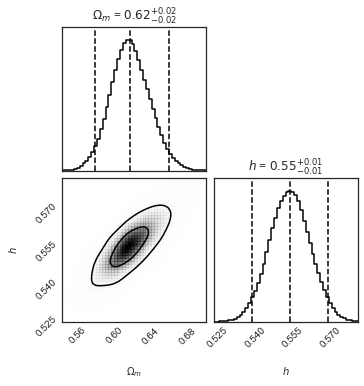

In [40]:
fig = corner.corner(sampler.flatchain,labels=labels,bins=50,plot_datapoints=False,smooth=2., 
                    smooth1d=2.,levels=(1.-np.exp(-0.5),1.-np.exp(-2.)),quantiles=[.025,0.5,0.975],show_titles=True);

In [41]:
#fig.savefig('corner_plot.pdf')

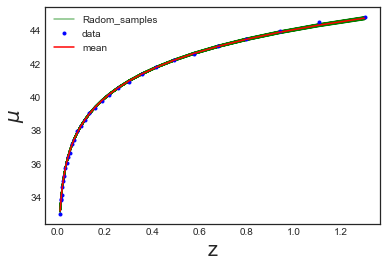

In [42]:
figure = plt.figure()
for c1,c2 in sampler.flatchain[np.random.randint(len(sampler.flatchain), size=200)]:
    fig1,=plt.plot(data_mu[0],mu([c1,c2],data_mu[0]),'g',alpha=0.5);

fig2, = plt.plot(data_mu[0],data_mu[1],'.b');

fig3, =plt.plot(data_mu[0],mu([np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1])],data_mu[0]),'r');

plt.legend([fig1,fig2,fig3],['Radom_samples','data','mean'],loc='best')
plt.xlabel('z',fontsize=20);
plt.ylabel(r'$\mu$',fontsize=20);


In [43]:
#figure.savefig('data_vs_model.pdf')

# Now the proper model

As i mentioned before, the expresion for $D_L(z)$ that we have is only valid for a flat universe $\Omega = \Omega_m + \Omega_v = 1$. The proper way to calculate the Luminosity Distance is 

$D_L(z) = \frac{(1+z)c}{H_0\sqrt{|1-\Omega|}}S_k(r)$

where $S_k(r) = \text{sin}r, r, \text{sinh}r$ if $\Omega >1, =1$ or $<1$ and $r(z)$ 

$r(z) = \sqrt{|1-\Omega|}\int_0^z\frac{dz'}{\sqrt{\Omega_m(1+z')^3+\Omega_v+(1-\Omega)(1+z')^2}}$